## Data exploration
### Import data and evaluate class imbalance

1. Read the CSV file *train.csv* containing the mapping from images to labels.
2. Count the number of samples per label to see if the data is balanced.


In [3]:
import numpy as np
import pandas as pd

# read train.csv into a pandas dataframe
data_description = pd.read_csv('train.csv')

# create list of labels
labels = data_description.label
labels = list(labels)

# count occurence of each label and print them
print(f'# of all labels: {len(labels)}')
L = len(labels)
c0 = labels.count(0)
c1 = labels.count(1)
c2 = labels.count(2)
c3 = labels.count(3)
c4 = labels.count(4)

print(f'c0: {c0} ratio: {100*c0/L}%')
print(f'c1: {c1} ratio: {100*c1/L}%')
print(f'c2: {c2} ratio: {100*c2/L}%')
print(f'c3: {c3} ratio: {100*c3/L}%')
print(f'c4: {c4} ratio: {100*c4/L}%')

# of all labels: 21397
c0: 1087 ratio: 5.080151423096696%
c1: 2189 ratio: 10.230406131700706%
c2: 2386 ratio: 11.151095948030097%
c3: 13158 ratio: 61.49460204701594%
c4: 2577 ratio: 12.043744450156565%


## Plot class imbalance

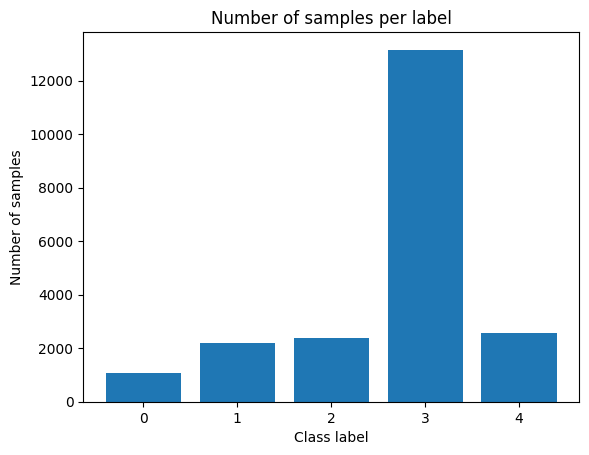

In [4]:
import matplotlib.pyplot as plt

# Count the number of samples for each label
counts = [c0, c1, c2, c3, c4]

# Set the x-axis labels
labels = ['0', '1', '2', '3', '4']

# Create a bar chart
plt.bar(labels, counts)

# Add a title to the chart
plt.title('Number of samples per label')

# Add labels to the axes
plt.xlabel('Class label')
plt.ylabel('Number of samples')

# Display the chart
plt.show()

In [5]:
# print dataframe to know how it looks like
data_description

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


## Show image augmentation

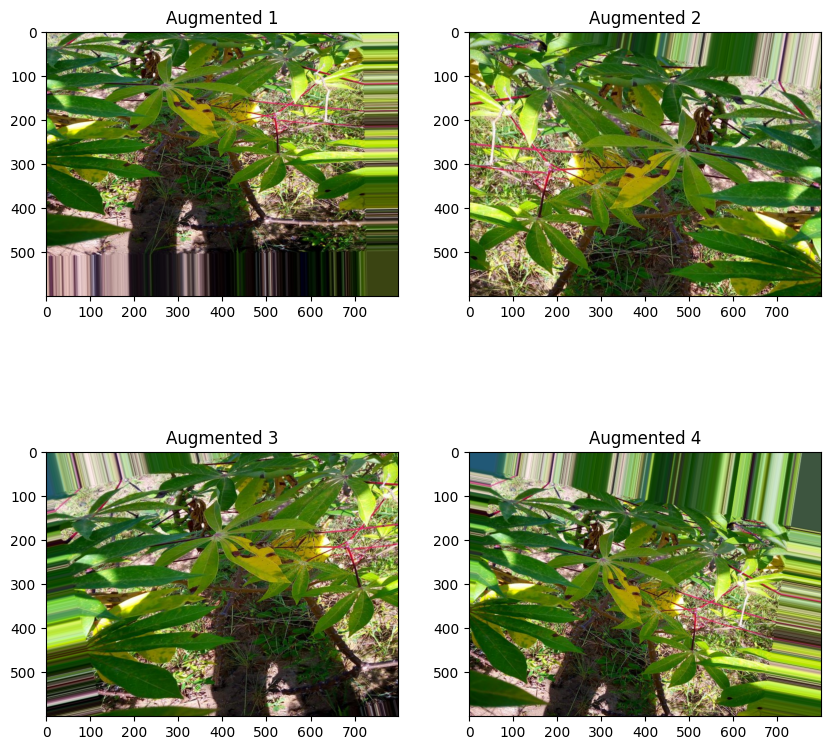

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the image using pandas
data_description = pd.read_csv('train.csv')
image_path = 'train_images/' + data_description['image_id'][0]
image = plt.imread(image_path)

# Create an image generator with data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Generate augmented images
augmented_images = datagen.flow(np.array([image]), batch_size=1)

# Plot the original and augmented images in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original')
for i in range(2):
    for j in range(2):
        axs[i, j].imshow(augmented_images.next().squeeze().astype(int))
        axs[i, j].set_title(f'Augmented {i*2+j+1}')
plt.show()

### Balance out the classes to limit model bias

In [6]:
# Set the desired number of samples for each label
desired_samples = 256

# Group the dataframe by label
grouped = data_description.groupby('label')

# Create an empty dataframe to store the sampled data
sampled_data = pd.DataFrame()

# Loop through each group
for label, group in grouped:
    # If the group has more samples than the desired number of samples, sample a subset
    if len(group) > desired_samples:
        group = group.sample(desired_samples)
    # Append the sampled data to the new dataframe
    sampled_data = pd.concat([sampled_data, group])

# Reset the index of the new dataframe
sampled_data = sampled_data.reset_index(drop=True)
sampled_data

,image_id,label
0,987080644.jpg,0
1,3614778275.jpg,0
2,4288369732.jpg,0
3,815758241.jpg,0
4,3880254716.jpg,0
...,...,...
1275,1740920965.jpg,4
1276,1965850227.jpg,4
1277,3369127189.jpg,4
1278,1990899878.jpg,4


## Print the class ratio again

In [7]:
nl = sampled_data.label
nl = list(nl)

print(f'# of all labels: {len(nl)}')
L = len(nl)
c0 = nl.count(0)
c1 = nl.count(1)
c2 = nl.count(2)
c3 = nl.count(3)
c4 = nl.count(4)

print(f'c0: {c0} ratio: {100*c0/L}%')
print(f'c1: {c1} ratio: {100*c1/L}%')
print(f'c2: {c2} ratio: {100*c2/L}%')
print(f'c3: {c3} ratio: {100*c3/L}%')
print(f'c4: {c4} ratio: {100*c4/L}%')

# of all labels: 1280
c0: 256 ratio: 20.0%
c1: 256 ratio: 20.0%
c2: 256 ratio: 20.0%
c3: 256 ratio: 20.0%
c4: 256 ratio: 20.0%


## Try first pretrained model (EfficientNetB0)

### Create image generators which will then be used to efficiently draw images from files during training

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
STEPS_PER_EPOCH = len(sampled_data)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(sampled_data)*0.2 / BATCH_SIZE
EPOCHS = 5
TARGET_SIZE = 224

# Set the path to the directory containing the image files
image_dir = 'train_images'

# Define the image data generator
data_generator = ImageDataGenerator(
    # rescale=1./255,
    validation_split=0.2
)

sampled_data.label = sampled_data.label.astype('str')

# Create the generator for the training set
train_generator = data_generator.flow_from_dataframe(
    dataframe=sampled_data,
    directory=image_dir,
    x_col='image_id',
    y_col='label',
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True,
    class_mode='sparse'
)

# Create the generator for the validation set
validation_generator = data_generator.flow_from_dataframe(
    dataframe=sampled_data,
    directory=image_dir,
    x_col='image_id',
    y_col='label',
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=32,
    subset='validation',
    shuffle=True,
    class_mode='sparse'
)


Found 1024 validated image filenames belonging to 5 classes.
Found 256 validated image filenames belonging to 5 classes.


### Define the model

In [9]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from keras.optimizers import Adam


def create_model():
    model = models.Sequential()

    model.add(EfficientNetB0(include_top = False, weights = 'imagenet',
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


c:\Users\wojtek\.virtualenvs\AMLS_II_assignment22_23-asFhsxhl\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Create the scheduling mechanism for model training

In [ ]:
# save model after each epoch if it performed better than before
model_save = ModelCheckpoint('./best_baseline_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
# stop the training when there was no improvement in validation loss for 5 consecutive epochs
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
# reduce the learning rate if the gradient descent reaches a plateau (flat surface)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit_generator(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/20
256/256 [==============================] - ETA: 0s - loss: 1.6415 - acc: 0.2815
Epoch 00001: val_loss improved from inf to 2.33821, saving model to ./best_baseline_model.h5
256/256 [==============================] - 113s 443ms/step - loss: 1.6415 - acc: 0.2815 - val_loss: 2.3382 - val_acc: 0.2881
Epoch 2/20
256/256 [==============================] - ETA: 0s - loss: 1.4617 - acc: 0.3225
Epoch 00002: val_loss improved from 2.33821 to 1.70504, saving model to ./best_baseline_model.h5
256/256 [==============================] - 87s 340ms/step - loss: 1.4617 - acc: 0.3225 - val_loss: 1.7050 - val_acc: 0.2549
Epoch 3/20
256/256 [==============================] - ETA: 0s - loss: 1.4363 - acc: 0.3491
Epoch 00003: val_loss did not improve from 1.70504
256/256 [==============================] - 86s 338ms/step - loss: 1.4363 - acc: 0.3491 - val_loss: 2.4291 - val_acc: 0.2656
Epoch 4/20
256/256 [==============================] - ETA: 0s - loss: 1.4010 - acc: 0.3633
Epoch 00004: val_loss 

## Plot the training and validation curves

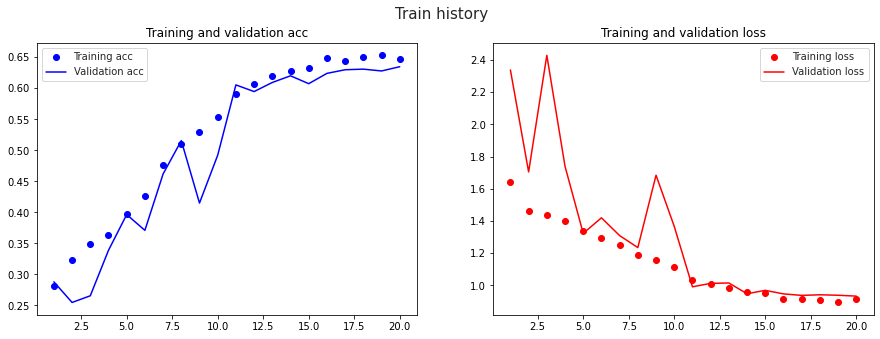

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

## Save the model

In [ ]:
model.save('./baseline_model.h5')

## Show saliency map for model for a chosen image

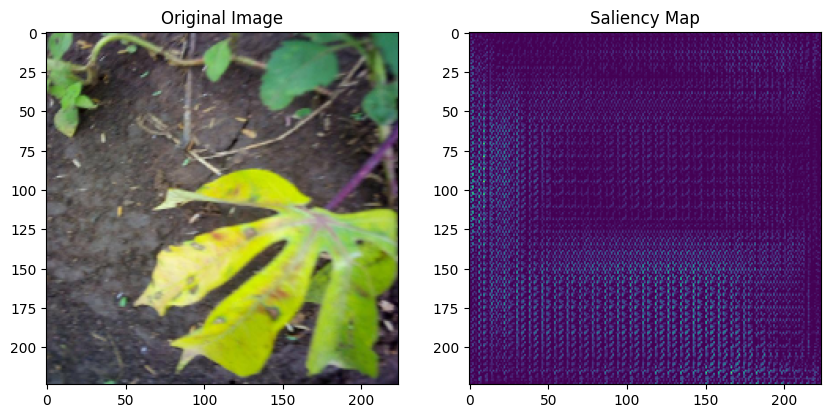

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image



BATCH_SIZE = 16
# STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
# VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 20
TARGET_SIZE = 224




# Load the trained model from the .h5 file
model = load_model('results/baseline_model.h5')



# Load a single test image
img_path = 'train_images/5511383.jpg'
img = image.load_img(img_path, target_size=(TARGET_SIZE, TARGET_SIZE))
img_arr = image.img_to_array(img)
img_arr /= 255.0
img_arr = np.expand_dims(img_arr, axis=0)

# Generate the saliency map
with tf.GradientTape() as tape:
    inputs = tf.cast(img_arr, tf.float32)
    tape.watch(inputs)
    predictions = model(inputs)
    top_prediction = tf.argmax(predictions[0])
    top_class_channel = predictions[:, top_prediction]
grads = tape.gradient(top_class_channel, inputs)[0]
grads = tf.reduce_mean(grads, axis=-1)
grads = np.maximum(grads, 0) / np.max(grads)

# Plot the original image and the saliency map side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_arr[0])
axs[0].set_title('Original Image')
axs[1].imshow(grads)
axs[1].set_title('Saliency Map')
plt.show()

## Plot confusion matrix

In [ ]:


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


# Get the true labels from the validation set generator
true_labels = validation_generator.classes

model = load_model('results/models/baseline_model.h5')


# Make predictions using the model and get the predicted labels
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get the class names for the labels
class_names = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

8/8 [==============================] - 24s 3s/step


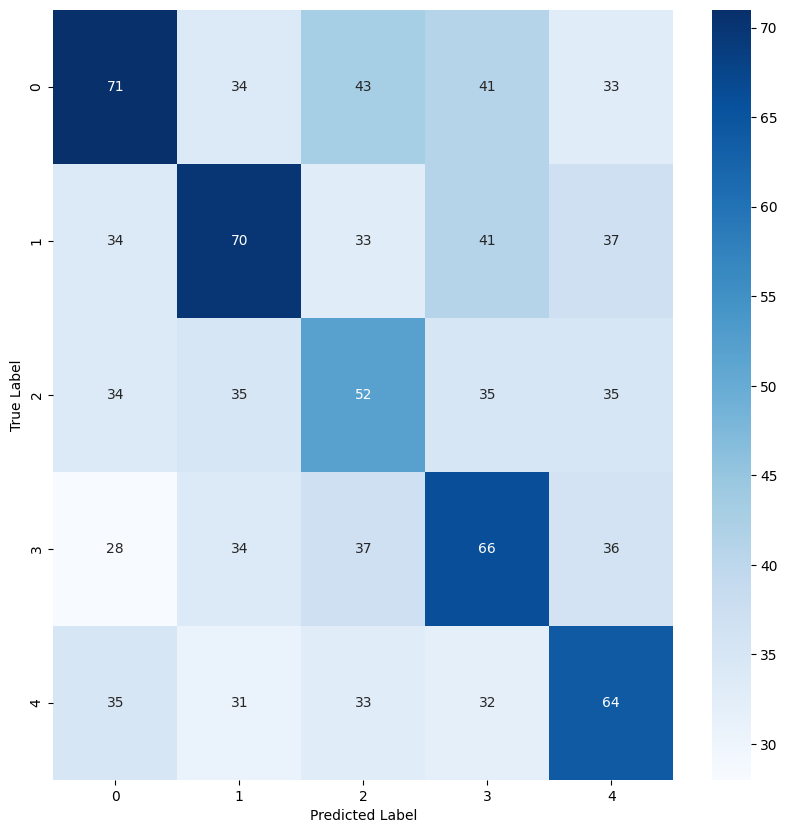

In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

## Create a custom model

In [ ]:
def create_model():
    model = models.Sequential()
    
    
    model.add(layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.6))
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())

#     model.add(EfficientNetB0(include_top = False, weights = 'imagenet',
#                              input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))

    
#     model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))

    model.compile(optimizer = Adam(learning_rate = 0.01),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [ ]:
model = create_model()
# model.summary()

In [ ]:
# save model after each epoch if it performed better than before
model_save = ModelCheckpoint('./best_baseline_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
# stop the training when there was no improvement in validation loss for 5 consecutive epochs
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
# reduce the learning rate if the gradient descent reaches a plateau (flat surface)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit_generator(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/20
256/256 [==============================] - ETA: 0s - loss: 12.1910 - acc: 0.2107
Epoch 00001: val_loss improved from inf to 1.57372, saving model to ./best_baseline_model.h5
256/256 [==============================] - 106s 412ms/step - loss: 12.1910 - acc: 0.2107 - val_loss: 1.5737 - val_acc: 0.2676
Epoch 2/20
256/256 [==============================] - ETA: 0s - loss: 1.6070 - acc: 0.2571
Epoch 00002: val_loss did not improve from 1.57372
256/256 [==============================] - 81s 317ms/step - loss: 1.6070 - acc: 0.2571 - val_loss: 1.5967 - val_acc: 0.2402
Epoch 3/20
256/256 [==============================] - ETA: 0s - loss: 1.5927 - acc: 0.2737
Epoch 00003: val_loss improved from 1.57372 to 1.53311, saving model to ./best_baseline_model.h5
256/256 [==============================] - 81s 318ms/step - loss: 1.5927 - acc: 0.2737 - val_loss: 1.5331 - val_acc: 0.2998
Epoch 4/20
256/256 [==============================] - ETA: 0s - loss: 1.5712 - acc: 0.2825
Epoch 00004: val_los

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 256)   7168      
_________________________________________________________________
batch_normalization_3 (Batch (None, None, None, 256)   1024      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 256)   0         
_________________________________________________________________
dropout_3 (Dropout)          (None, None, None, 256)   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 128)   295040    
_________________________________________________________________
batch_normalization_4 (Batch (None, None, None, 128)   512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 128)  

### Show results

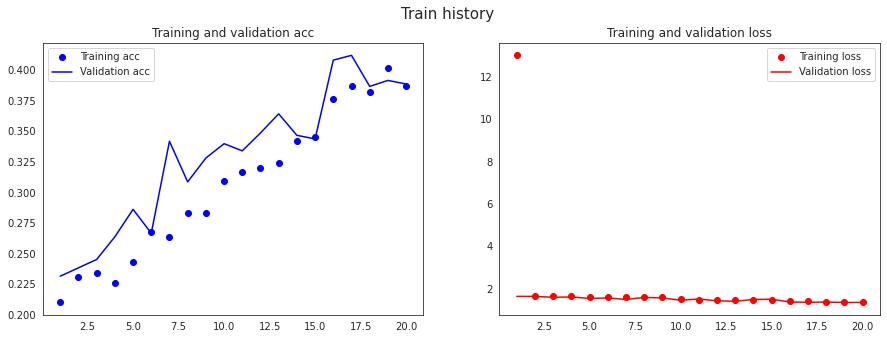

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

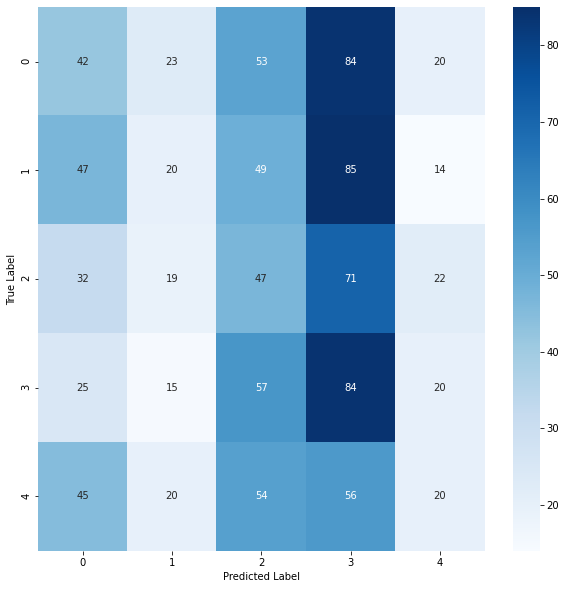

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels from the validation set generator
true_labels = validation_generator.classes

# Make predictions using the model and get the predicted labels
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get the class names for the labels
class_names = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()